In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from IPython.display import Image
from qutip import *
from math import sqrt
from scipy.optimize import curve_fit

Questions
- why does the hamiltonian have additional + H1 and + H2 of the individual systems? - I may be missing an interaction term?
- rabi oscillations should have a bouncing photon and still work, with two it works on this sim but not with one
- why do rabi oscillation frequencies differ from prediction?
- is there just one rabi frequency for the whole system?
- why does everything go crazy when the qubits start in different states
- what is iswap gate
- how to calc fidelty, what is concurrence?

In [48]:
#
# System Constants
#

# aha! this example notebook couples two cubits to one cavity but it uses a gate? 
# https://nbviewer.ipython.org/github/jrjohansson/qutip-lectures/blob/master/Lecture-2A-Cavity-Qubit-Gates.ipynb

# constants sources: 
# https://www.nature.com/articles/nature06184 - the useful article
# https://aip.scitation.org/doi/10.1063/1.5089729 - has useful information but for 4 qubits coupled to individual cavities
GHz = 10**9 #Hz
wq1 = 3.04 * GHz * 2* np.pi # 6.617 * GHz * 2* np.pi # wq = sqrt(8EjEc)
wq2 = 2.96 * GHz * 2* np.pi # 2.88 * GHz * 2* np.pi # 6.529 * GHz * 2* np.pi
wc = 3 * GHz * 2* np.pi # 5.19 * GHz * 2 * np.pi
g1 = 0.04 * GHz * 2 * np.pi # 0.105 * GHz * 2 * np.pi
g2 = 0.04 * GHz * 2 * np.pi # g1
N = 20
use_rwa = False 
n_th_a = 0.0
n = 0
# times to eveole over
tlist = np.linspace(0, 25/GHz,100)


In [49]:
#
# Operators, Hamiltonion
#

# cavity operators
a = tensor(destroy(N), qeye(2), qeye(2))
nc = a.dag()*a

# qubit 1 operators
sm1 = tensor(qeye(N), destroy(2), qeye(2))
sz1 = tensor(qeye(N), sigmaz(), qeye(2))
nq1 = sm1.dag() * sm1

# qubit 2 operators 
sm2 = tensor(qeye(N), qeye(2), destroy(2))
sz2 = tensor(qeye(N), qeye(2), sigmaz())
nq2 = sm2.dag() * sm2

# small hamiltionians for each system
Hc = nc
Hq1 = -0.5 * sz1 
Hq2 = -0.5 * sz2
if use_rwa:
    Hc1 = g1 * (a.dag()*sm1 + a*sm1.dag())
    Hc2 = g2 * (a.dag()*sm2 + a*sm2.dag())
else:
    Hc1 = g1 * (a.dag() + a)*(sm1 + sm1.dag())
    Hc2 = g2 * (a.dag() + a)*(sm2 + sm2.dag())

#Hamiltonian: Jaynes-Cumming - maybe a different one based on the nature article
H = wc * Hc + wq1 * Hq1 + wq2 * Hq2 + Hc1 + Hc2

In [50]:
#
# Initial state
#

evals, ekets = H.eigenstates()
psi_gnd = ket2dm(ekets[0]) #ground state density matrix
psi_e1 = ket2dm(ekets[1])
psi_gnd
#psi_e1

Quantum object: dims = [[20, 2, 2], [20, 2, 2]], shape = (80, 80), type = oper, isherm = True
Qobj data =
[[0.99991103 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]

In [51]:
#
# Calculate expected Rabi Oscillations for System
#

## https://www.nature.com/articles/s41598-018-35751-3 
## https://iopscience.iop.org/article/10.1088/2399-6528/aadafc
## https://iopscience.iop.org/article/10.1088/1751-8113/46/33/335301/pdf?casa_token=HrohioirAlUAAAAA:G4ZDAnpHl7a3eapu7MBpEGyPgKGOp56XtJpIBNuwZkZnE3MKvOxEWDjzLNAPCy-k0c3q0ff7NQ
## https://www.nature.com/articles/nphys1731
## https://www.nature.com/articles/s41598-019-40899-7 had a thing didn't know what delta was
## https://www.sciencedirect.com/science/article/pii/S1631070516300585 
## https://edoc.ub.uni-muenchen.de/10291/1/Helmer_Ferdinand.pdf end of chapter 1 super helpful, ~pg 47 of doc
## https://physics.stackexchange.com/questions/495374/detuning-in-rabi-oscillations 
## https://www.fulviofrisone.com/attachments/article/404/Fox%20M.%20Quantum%20optics..%20an%20introduction%20(Oxford,%202006)(ISBN%200198566735)(397s)_PQ
r1 = sqrt(2*4*(g1**2)*(n + 1) + (wq1-wc)**2)/GHz
r2 = sqrt(2*4*(g2**2)*(n + 1) + (wq2-wc)**2)/GHz
print(f"qubit 1 rabi frequency {r1}, qubit 2 rabi frequency {r2}")


qubit 1 rabi frequency 0.7539822368615512, qubit 2 rabi frequency 0.7539822368615499


In [52]:

# cavity dissapation rate
kappa = 0.0* GHz * 2* np.pi # 0.033 * 2 * np.pi * GHz
# qubit dissapation rate
gamma1 = 0 * GHz * 2* np.pi
gamma2 = 0 * GHz * 2* np.pi


# create dissapation operators list (not sure why the list is needed)
collapse_ops = [sqrt(kappa) * a, sqrt(gamma1) * sm1, sqrt(gamma2) * sm2] # add another operator for thermal interference if necessary

    
    
# put qubit in excited state to start 
psi0 = tensor(basis(N,1), basis(2,0), basis(2,0)) # basis matrices are the levels of the first and second qubit respectively, the basis is the cavity
    
# make the system evolve 
output = mesolve(H, psi0, tlist, collapse_ops, [nc, nq1, nq2])

Rabi Frequency from fitting qubit 1: 0.9261530967860332GHz, period: 1.079735092902278 ns
Rabi Frequency from fitting qubit 2: 0.9204750733795262GHz, period: 1.0863955243551549 ns
Rabi Frequency from fitting cavity: 0.9236178950248956GHz, period: 1.08269881450602 ns


Text(0.5, 1.0, 'Vacuum Rabi oscillations')

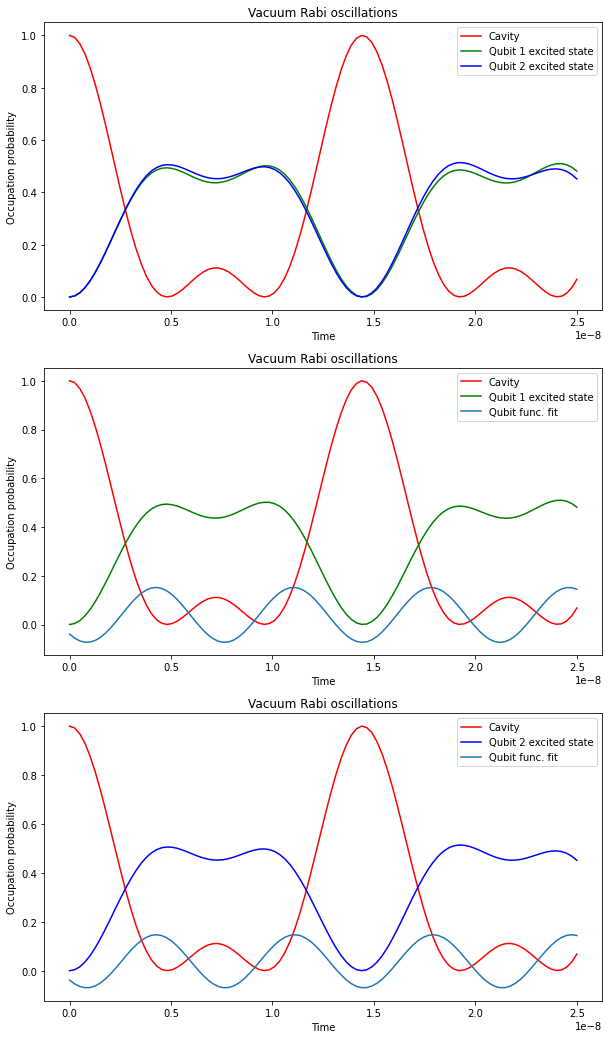

In [53]:
n_c = output.expect[0]
n_q1 = output.expect[1]
n_q2 = output.expect[2]

# The fit function
# Only use if you expect sinusoidal behavior
def test(x, a, b,c, d):
    return a*np.sin(b*x + c) + d
# get fit functions for both results
param1, param_cov1 = curve_fit(test, tlist, n_q1, maxfev=5000, p0=[1,r1*GHz, 0, 0.5])
fit_func_q1 = param1[0]*(np.sin(param1[1]*tlist + param1[2]) + param1[3])

param2, param_cov2 = curve_fit(test, tlist, n_q2, maxfev=5000, p0=[1,r2*GHz, -np.pi/2, 0.9])
fit_func_q2 = param2[0]*(np.sin(param2[1]*tlist + param2[2]) + param2[3])

param3, param_cov3 = curve_fit(test, tlist, n_c, maxfev=5000, p0=[1,(r1+r2)/2*GHz, -np.pi/2, 0.9])
fit_func_c = param3[0]*(np.sin(param3[1]*tlist + param3[2]) + param3[3])

print(f"Rabi Frequency from fitting qubit 1: {abs(param1[1])/GHz}GHz, period: {1/abs(param1[1])*GHz} ns")
print(f"Rabi Frequency from fitting qubit 2: {abs(param2[1])/GHz}GHz, period: {1/abs(param2[1])*GHz} ns")
print(f"Rabi Frequency from fitting cavity: {abs(param3[1])/GHz}GHz, period: {1/abs(param3[1])*GHz} ns")

# Oscillations with both qubits
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(10,18))
axes[0].plot(tlist, n_c, 'r', label="Cavity")
axes[0].plot(tlist, n_q1, 'g', label="Qubit 1 excited state")
axes[0].plot(tlist, n_q2, 'b',  label="Qubit 2 excited state")
axes[0].legend(loc=0)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Occupation probability')
axes[0].set_title('Vacuum Rabi oscillations')

# Oscillations with q1 and cavity
axes[1].plot(tlist, n_c, 'r', label="Cavity")
axes[1].plot(tlist, n_q1, 'g', label="Qubit 1 excited state")
axes[1].plot(tlist, fit_func_q1, label="Qubit func. fit")
axes[1].legend(loc=0)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Occupation probability')
axes[1].set_title('Vacuum Rabi oscillations')

# Oscillations with q2 and cavity
axes[2].plot(tlist, n_c, 'r', label="Cavity")
axes[2].plot(tlist, n_q2, 'b',  label="Qubit 2 excited state")
axes[2].plot(tlist, fit_func_q2, label="Qubit func. fit")
axes[2].legend(loc=0)
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Occupation probability')
axes[2].set_title('Vacuum Rabi oscillations')